## Define the plotter and BN and RC blocks

In [37]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class GradientFlowPlotter:
    def __init__(self, model, plot_func):
        self.model = model
        self.plot_func = plot_func  # Function to create the plot

    def plot_grad_flow(self, named_parameters):
        all_grads = []
        layers = []

        for name, parameter in named_parameters:
            if parameter.grad is not None:  # Check if the gradient exists
                layers.append(name)
                grad_mean = parameter.grad.abs().mean().detach().cpu().numpy()
                all_grads.append(grad_mean)
            else:
                layers.append(name)
                all_grads.append(0.0)  # Use 0 if no gradient is available

        return self.plot_func(all_grads, layers)

    def plot_all_epochs(self, model_path_format, num_epochs, dummy_input):
        for epoch in range(1, num_epochs + 1):
            # Load the model state
            model_path = model_path_format.format(epoch)
            self.model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
            self.model.eval()

            # Perform a forward and backward pass with dummy input
            dummy_output = self.model(dummy_input)
            loss = dummy_output.mean()  # Simplified dummy loss for demonstration
            self.model.zero_grad()
            loss.backward()

            # Plot gradient flow for this epoch
            print(f"Plotting gradient flow for epoch {epoch}")
            plt = self.plot_grad_flow(self.model.named_parameters())
            plt.show()  # Display the plot for the current epoch

In [38]:
import torch.nn.functional as F
class BN_RC_ConvolutionalProcessingBlock(nn.Module):
    def __init__(self, input_shape, num_filters, kernel_size, padding, bias, dilation):
        super(BN_RC_ConvolutionalProcessingBlock, self).__init__()

        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.input_shape = input_shape
        self.padding = padding
        self.bias = bias
        self.dilation = dilation

        self.build_module()

    def build_module(self):
        self.layer_dict = nn.ModuleDict()
        x = torch.zeros(self.input_shape)
        out = x
        self.layer_dict['conv_0'] = nn.Conv2d(in_channels=out.shape[1], out_channels=self.num_filters, bias=self.bias,
                                              kernel_size=self.kernel_size, dilation=self.dilation,
                                              padding=self.padding, stride=1)
        # First batch normalisation layer
        self.layer_dict['bn_0'] = nn.BatchNorm2d(self.num_filters)

        out = self.layer_dict['conv_0'].forward(out)
        out = self.layer_dict['bn_0'].forward(out)
        out = F.leaky_relu(out)

        self.layer_dict['conv_1'] = nn.Conv2d(in_channels=out.shape[1], out_channels=self.num_filters, bias=self.bias,
                                              kernel_size=self.kernel_size, dilation=self.dilation,
                                              padding=self.padding, stride=1)
        # Second batch normalisation layer
        self.layer_dict['bn_1'] = nn.BatchNorm2d(self.num_filters)

        out = self.layer_dict['conv_1'].forward(out)
        out = self.layer_dict['bn_1'].forward(out)
        out = F.leaky_relu(out)

        print(out.shape)

    def forward(self, x):
        out = x
        # Store the residual layer
        residual = x
        out = self.layer_dict['conv_0'].forward(out)
        out = self.layer_dict['bn_0'].forward(out)
        out = F.leaky_relu(out)

        out = self.layer_dict['conv_1'].forward(out)
        out = self.layer_dict['bn_1'].forward(out)
        # Add before activation
        out += residual
        out = F.leaky_relu(out)

        return out


class BN_RC_ConvolutionalDimensionalityReductionBlock(nn.Module):

    def __init__(self, input_shape, num_filters, kernel_size, padding, bias, dilation, reduction_factor):
        super(BN_RC_ConvolutionalDimensionalityReductionBlock, self).__init__()

        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.input_shape = input_shape
        self.padding = padding
        self.bias = bias
        self.dilation = dilation
        self.reduction_factor = reduction_factor
        self.build_module()

    def build_module(self):
        self.layer_dict = nn.ModuleDict()
        x = torch.zeros(self.input_shape)
        out = x

        self.layer_dict['conv_0'] = nn.Conv2d(in_channels=out.shape[1], out_channels=self.num_filters, bias=self.bias,
                                              kernel_size=self.kernel_size, dilation=self.dilation,
                                              padding=self.padding, stride=1)
        # First batch normalisation layer
        self.layer_dict['bn_0'] = nn.BatchNorm2d(self.num_filters)

        out = self.layer_dict['conv_0'].forward(out)
        out = self.layer_dict['bn_0'].forward(out)
        out = F.leaky_relu(out)

        out = F.avg_pool2d(out, self.reduction_factor)

        self.layer_dict['conv_1'] = nn.Conv2d(in_channels=out.shape[1], out_channels=self.num_filters, bias=self.bias,
                                              kernel_size=self.kernel_size, dilation=self.dilation,
                                              padding=self.padding, stride=1)
        # Second batch normalisation layer
        self.layer_dict['bn_1'] = nn.BatchNorm2d(self.num_filters)

        out = self.layer_dict['conv_1'].forward(out)
        out = self.layer_dict['bn_1'].forward(out)
        out = F.leaky_relu(out)

        print(out.shape)

    def forward(self, x):
        out = x

        out = self.layer_dict['conv_0'].forward(out)
        out = self.layer_dict['bn_0'].forward(out)
        out = F.leaky_relu(out)

        out = F.avg_pool2d(out, self.reduction_factor)

        out = self.layer_dict['conv_1'].forward(out)
        out = self.layer_dict['bn_1'].forward(out)
        out = F.leaky_relu(out)

        return out
    



## Plotter Function

In [94]:
def plot_func_def(all_grads, layers, ax):
    """
    Plot function definition to plot the average gradient with respect to the number of layers in the given model
    :param all_grads: Gradients wrt weights for each layer in the model.
    :param layers: Layer names corresponding to the model parameters
    :return: plot for gradient flow
    """
    ax.plot(all_grads, alpha=0.3, color="b")
    ax.hlines(0, 0, len(all_grads)+1, linewidth=1, color="k" )
    # ax.set_xticks(range(0,len(all_grads), 1), layers, rotation="vertical")
    reduced_ticks = range(0, len(layers), 2)
    ax.set_xticks(reduced_ticks)
    ax.set_xticklabels([layers[i] for i in reduced_ticks], rotation="vertical")
    ax.set_xlim(xmin=0, xmax=len(all_grads))
    # ax.set_xlabel("Layers")
    # ax.set_ylabel("Average Gradient")
    # ax.set_title("Gradient flow")
    # ax.grid(True)
    # fig.tight_layout()
    return ax
    

def plot_grad_flow(named_parameters, ax):
    """
    Receives the parameters of the model being trained. Returns plot of gradient flow for the given model parameters.
    """
    all_grads = []
    layers = []
    
    for layer, parameter in named_parameters:
        if "bias" in layer:
            continue
        layer_name = layer.replace('.weight', '').replace('.bias', '').replace("layer_dict.", "").replace(".", "_")

        mean_grad = parameter.grad.abs().mean().item()
        layers.append(layer_name)
        all_grads.append(mean_grad)
    axs = plot_func_def(all_grads, layers, ax)
    return axs

<Figure size 640x480 with 0 Axes>

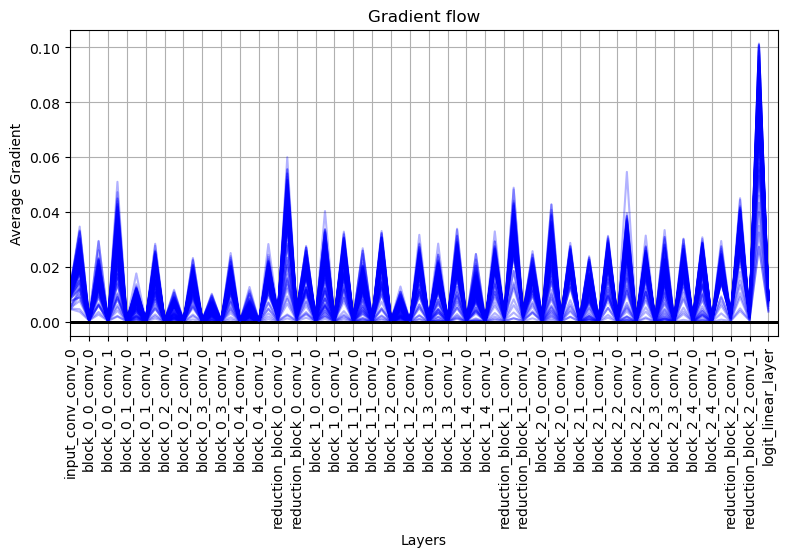

In [108]:
from pytorch_mlp_framework.model_architectures import *
from contextlib import redirect_stdout
import os
with open(os.devnull, 'w') as fnull, redirect_stdout(fnull):
    model = ConvolutionalNetwork(  # initialize our network object, in this case a ConvNet
        input_shape=(100, 3, 32, 32),
        num_output_classes=100, num_filters=32, use_bias=False,
        num_blocks_per_stage=5, num_stages=3,
        processing_block_type=BN_RC_ConvolutionalProcessingBlock,
        dimensionality_reduction_block_type=BN_RC_ConvolutionalDimensionalityReductionBlock)


dummy_input = torch.randn(100, 3, 32, 32)  # Adjust to your input shape
dummy_target = torch.randint(0, 100, (100,))  # Dummy target for classification

criterion = nn.CrossEntropyLoss()

# Path format for saved models
PATH = "/Users/AlexDronov/Desktop/MSc Data Science/mlpractical/\
VGG_38_BN_RC_experiment/saved_models/train_model_{}"
plt.figure()
fig, ax = plt.subplots(figsize = (8,4))

ax.set_xlabel("Layers")
ax.set_ylabel("Average Gradient")
ax.set_title("Gradient flow")
ax.grid(True)
fig.tight_layout()

for epoch in range(0, 100):
    checkpoint = torch.load(PATH.format(epoch), map_location=torch.device('cpu'), weights_only=False)
    state_dict = checkpoint['network']
    state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}
    model.load_state_dict(state_dict)
    outputs = model(dummy_input)

    # Compute loss
    loss = criterion(outputs, dummy_target)

    # Backward pass to compute gradients
    model.zero_grad()  # Clear previous gradients
    loss.backward()
    
    # Plot gradient flow
    plot_grad_flow(model.named_parameters(), ax)

fig.savefig("../vgg_38_bc_rn_gradflow_plot.pdf",
            dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        metadata=None)

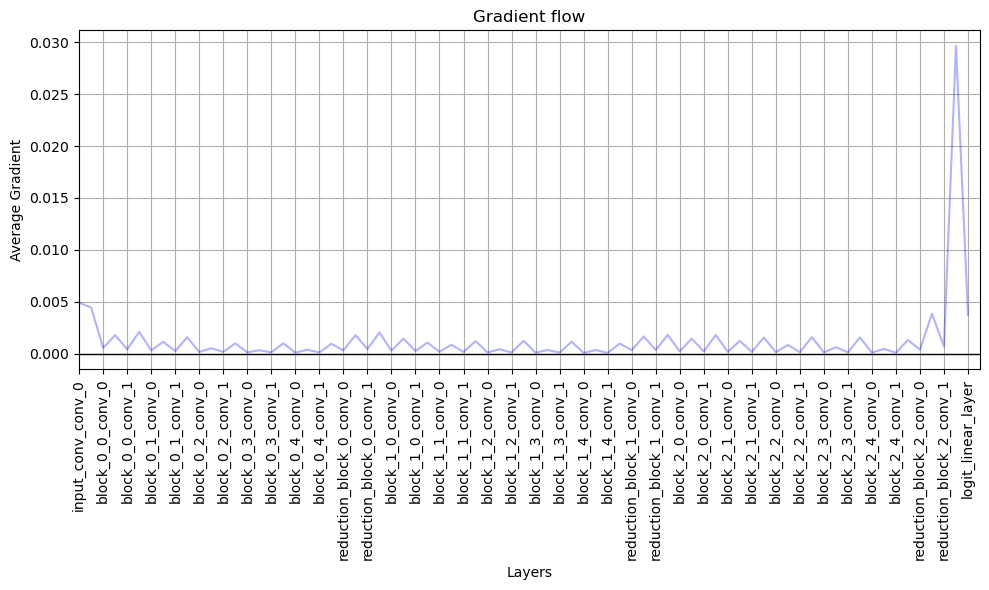

In [72]:
from IPython.display import display
display(plot)

In [66]:
checkpoint = torch.load(PATH.format(99), map_location=torch.device('cpu'), weights_only=False)
state_dict = checkpoint['network']
state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}
model.load_state_dict(state_dict)
for key, _ in model.named_parameters():
    print(key.replace('.weight', '').replace('.bias', '').replace("layer_dict.", "").replace(".", "_"))

input_conv_conv_0
input_conv_bn_0
input_conv_bn_0
block_0_0_conv_0
block_0_0_bn_0
block_0_0_bn_0
block_0_0_conv_1
block_0_0_bn_1
block_0_0_bn_1
block_0_1_conv_0
block_0_1_bn_0
block_0_1_bn_0
block_0_1_conv_1
block_0_1_bn_1
block_0_1_bn_1
block_0_2_conv_0
block_0_2_bn_0
block_0_2_bn_0
block_0_2_conv_1
block_0_2_bn_1
block_0_2_bn_1
block_0_3_conv_0
block_0_3_bn_0
block_0_3_bn_0
block_0_3_conv_1
block_0_3_bn_1
block_0_3_bn_1
block_0_4_conv_0
block_0_4_bn_0
block_0_4_bn_0
block_0_4_conv_1
block_0_4_bn_1
block_0_4_bn_1
reduction_block_0_conv_0
reduction_block_0_conv_0
reduction_block_0_bn_0
reduction_block_0_bn_0
reduction_block_0_conv_1
reduction_block_0_conv_1
reduction_block_0_bn_1
reduction_block_0_bn_1
block_1_0_conv_0
block_1_0_bn_0
block_1_0_bn_0
block_1_0_conv_1
block_1_0_bn_1
block_1_0_bn_1
block_1_1_conv_0
block_1_1_bn_0
block_1_1_bn_0
block_1_1_conv_1
block_1_1_bn_1
block_1_1_bn_1
block_1_2_conv_0
block_1_2_bn_0
block_1_2_bn_0
block_1_2_conv_1
block_1_2_bn_1
block_1_2_bn_1
block_